## Missing value imputation

In [136]:
import pandas as pd

from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

import re
import numpy as np

In [111]:
df = pd.read_csv("../data/initial_data/frmgham2_project_data.csv")

In [112]:
# choose only period 3
# drop time columns, also, RANDID, and Death, since the target variable is CVD
df_3 = df[df['PERIOD'] == 3]
df_3 = df_3[[col for col in df_3.columns if not re.match('TIME',col) and col not in ['RANDID','DEATH']]]

In [113]:
features = list(df_3.columns)
features.remove("CVD")
df_3 = df_3[features + ['CVD']]

In [114]:
df_3

,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,CIGPDAY,BMI,DIABETES,BPMEDS,...,PERIOD,HDLC,LDLC,ANGINA,HOSPMI,MI_FCHD,ANYCHD,HYPERTEN,STROKE,CVD
1,1,209.0,52,121.0,66.0,0,0.0,NaN,0,0.0,...,3,31.0,178.0,0,1,1,1,0,0,1
4,2,237.0,58,108.0,66.0,0,0.0,28.50,0,0.0,...,3,54.0,141.0,0,0,0,0,0,0,0
11,2,NaN,58,155.0,90.0,1,30.0,24.61,0,0.0,...,3,NaN,NaN,0,0,0,0,1,0,0
14,2,220.0,55,180.0,106.0,0,0.0,31.17,1,1.0,...,3,46.0,135.0,0,0,1,1,1,0,1
19,2,320.0,57,110.0,46.0,1,30.0,22.02,0,0.0,...,3,34.0,286.0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11612,1,NaN,63,120.0,80.0,1,50.0,17.38,0,0.0,...,3,NaN,NaN,0,0,0,0,0,0,0
11615,2,228.0,60,205.0,100.0,1,20.0,22.37,0,0.0,...,3,47.0,181.0,0,0,0,0,1,0,0
11618,2,251.0,56,145.0,92.0,1,35.0,21.97,0,1.0,...,3,70.0,181.0,0,0,0,0,1,0,0
11623,1,153.0,52,143.0,89.0,0,0.0,25.74,0,0.0,...,3,30.0,123.0,0,0,0,0,1,0,0


In [115]:
# imput missings values
missings = df_3.isna().sum().to_frame().reset_index().rename(columns={"index":"Feature",0:"Missings"}).sort_values("Missings")
missings = missings[missings['Missings'] != 0]

missing_features = missings['Feature'].values.tolist()
missings

,Feature,Missings
10,HEARTRTE,4
6,CIGPDAY,14
7,BMI,17
12,educ,82
1,TOTCHOL,214
19,HDLC,236
20,LDLC,237
9,BPMEDS,446
11,GLUCOSE,562


In [116]:
missing_feaure_counts = df_3[missing_features].nunique().to_frame().reset_index()\
                .rename(columns={"index":'Feature',0:"N Unique"}).sort_values("N Unique")

missing_feaure_counts

,Feature,N Unique
7,BPMEDS,2
3,educ,4
1,CIGPDAY,35
0,HEARTRTE,74
5,HDLC,105
8,GLUCOSE,151
4,TOTCHOL,243
6,LDLC,262
2,BMI,1235


In [117]:
cat_missings = missing_feaure_counts[missing_feaure_counts['N Unique'] < 5]['Feature'].values
num_missings = missing_feaure_counts[missing_feaure_counts['N Unique'] > 3]['Feature'].values

In [118]:
imputer_num = KNNImputer()
imputer_cat = SimpleImputer(strategy='most_frequent')

In [119]:
X_cat,X_num = df_3[cat_missings].values,df_3[num_missings].values

X_cat = imputer_cat.fit_transform(X_cat)
X_num = imputer_num.fit_transform(X_num)

In [120]:
df_3_filled = df_3.copy()
df_3_filled[num_missings] = X_num
df_3_filled[cat_missings] = X_cat

In [121]:
# df_3_filled.isna().sum().to_frame()

In [122]:
X,y = df_3_filled.iloc[:,:-1].values,df_3_filled.iloc[:,-1].values

In [123]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=123)

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [124]:
tree = DecisionTreeClassifier()

tree = tree.fit(X_train,y_train)

In [125]:
tree.feature_importances_

array([0.00143943, 0.01327819, 0.0070231 , 0.01422518, 0.00617351,
       0.00172731, 0.00902546, 0.01322966, 0.        , 0.00091348,
       0.005996  , 0.0101564 , 0.00143943, 0.00240272, 0.        ,
       0.0093277 , 0.        , 0.00335672, 0.        , 0.02074076,
       0.01487236, 0.02780012, 0.        , 0.46297667, 0.05655202,
       0.00311191, 0.31423189])

In [126]:
perform_df = pd.DataFrame({features[i]:[tree.feature_importances_[i]] for i in range(len(features))}).T.reset_index().\
                        rename(columns={"index":"Feature",0:"Importance"}).sort_values("Importance")

# train_score_s,test_score_s = tree.score(X_s_train,y_s_train),tree.score(X_s_test,y_s_test)
# print(f"Missinga values have been droped, Decisoin tree:\n\t{name} data: [train score: {train_score_s}, test score: {test_score_s}]\n")


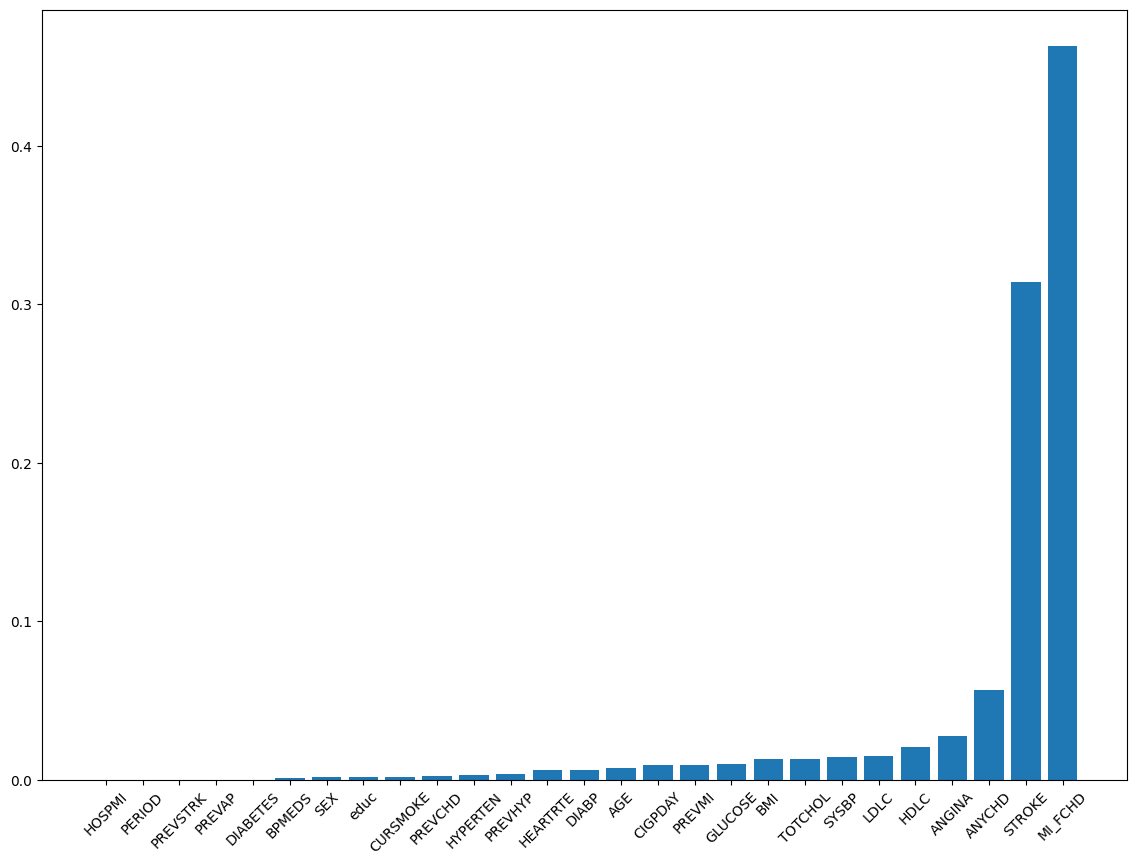

In [127]:
plt.figure(figsize=(14,10))

plt.bar(perform_df['Feature'],perform_df['Importance'])
plt.xticks(rotation=45)
plt.show()

In [145]:
rel_features = perform_df[perform_df['Importance']>.01]['Feature'].values.tolist()
rel_features

['GLUCOSE',
 'BMI',
 'TOTCHOL',
 'SYSBP',
 'LDLC',
 'HDLC',
 'ANGINA',
 'ANYCHD',
 'STROKE',
 'MI_FCHD']

In [146]:
rel_df = df_3[rel_features+['CVD']]

In [147]:
# pick the feautres, which importance is not zero based on decision tree

In [148]:
rel_df.to_csv("../data/model_data/period_3_rel_features_df_by_tree.csv",index=False)

In [149]:
rel_df

,GLUCOSE,BMI,TOTCHOL,SYSBP,LDLC,HDLC,ANGINA,ANYCHD,STROKE,MI_FCHD,CVD
1,92.0,NaN,209.0,121.0,178.0,31.0,0,1,0,1,1
4,71.0,28.50,237.0,108.0,141.0,54.0,0,0,0,0,0
11,NaN,24.61,NaN,155.0,NaN,NaN,0,0,0,0,0
14,81.0,31.17,220.0,180.0,135.0,46.0,0,1,0,1,1
19,87.0,22.02,320.0,110.0,286.0,34.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
11612,NaN,17.38,NaN,120.0,NaN,NaN,0,0,0,0,0
11615,91.0,22.37,228.0,205.0,181.0,47.0,0,0,0,0,0
11618,90.0,21.97,251.0,145.0,181.0,70.0,0,0,0,0,0
11623,72.0,25.74,153.0,143.0,123.0,30.0,0,0,0,0,0


In [100]:
tree.score(X_test,y_test)

0.9418070444104135

## Our logic

In [102]:
from sklearn.linear_model import LogisticRegression

In [105]:
n_features = len(features)

for i in range(n_features):

    feature = features[i]

    inner_df = df_3[[feature,'CVD']]

    